# k-Nearest Neighbor

In [1]:
###### IMPORTS ######
import os
import glob
from imutils import paths
import cv2
import numpy as np
import matplotlib.pyplot as plt
from knn_classifier import kNearestNeighbor

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 9) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
###### GLOBAL VARIABLES ######
# Labels
BACKGROUND = 0
POTATO = 1
CARROT = 2
CAT_SAL = 3
CAT_BEEF = 4
BUN = 5
ARM = 6
KETCHUP = 7

# Background mask
BGD_MASK = cv2.imread('../preprocessing/bgd_mask.jpg', cv2.IMREAD_COLOR)

# Average background image
AVG_BGD_MASK = cv2.imread('../preprocessing/avg_background.jpg', cv2.IMREAD_COLOR)

# Test directories
BGD_TEST_DIR = glob.glob('../dataset3/res_still/test/background/*.jpg')
POTATO_TEST_DIR = glob.glob('../dataset3/res_still/test/potato/*.jpg')
CARROT_TEST_DIR = glob.glob('../dataset3/res_still/test/carrots/*jpg')
CAT_SAL_TEST_DIR = glob.glob('../dataset3/res_still/test/catfood_salmon/*.jpg')
CAT_BEEF_TEST_DIR = glob.glob('../dataset3/res_still/test/catfood_beef/*.jpg')
BUN_TEST_DIR = glob.glob('../dataset3/res_still/test/bun/*.jpg')
ARM_TEST_DIR = glob.glob('../dataset3/res_still/test/arm/*.jpg')
KETCHUP_TEST_DIR = glob.glob('../dataset3/res_still/test/ketchup/*.jpg')

# Train directories
BGD_TRAIN_DIR = glob.glob('../dataset3/res_still/train/background/*.jpg')
POTATO_TRAIN_DIR = glob.glob('../dataset3/res_still/train/potato/*.jpg')
CARROT_TRAIN_DIR = glob.glob('../dataset3/res_still/train/carrots/*jpg')
CAT_SAL_TRAIN_DIR = glob.glob('../dataset3/res_still/train/catfood_salmon/*.jpg')
CAT_BEEF_TRAIN_DIR = glob.glob('../dataset3/res_still/train/catfood_beef/*.jpg')
BUN_TRAIN_DIR = glob.glob('../dataset3/res_still/train/bun/*.jpg')
ARM_TRAIN_DIR = glob.glob('../dataset3/res_still/train/arm/*.jpg')
KETCHUP_TRAIN_DIR = glob.glob('../dataset3/res_still/train/ketchup/*.jpg')

In [3]:
###### FUNCTIONS ######
def time_function(func, *args):
    """ 
    Call a function, func, with args and return the time, in [s],
    that it took to execute.
    """
    
    import time
    tic = time.time()
    func(*args)
    toc = time.time()
    
    return toc - tic

def extract_hist(image, bins=(8, 8, 8)):
    """
    Extracts a 3D color histogram from the hsv color space using
    the supplied number of bins per channel.
    """
    
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist(images=[hsv],
                       channels=[0, 1, 2],
                       mask=None,
                       histSize=bins,
                       ranges=[0, 180, 0, 256, 0, 256])
    cv2.normalize(src=hist, dst=hist)
    return hist.flatten()

## Full size image with no filter

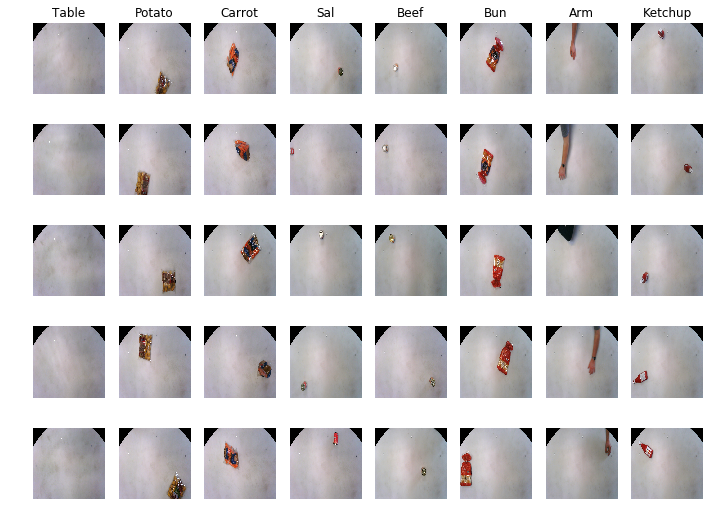

In [4]:
def import_data(X, y, folder, label, show_img):
    """ Imports data """
    
    if show_img is True:
        images = []

    for i, img in enumerate(folder):
        img = cv2.imread(img, cv2.IMREAD_COLOR)
        img = cv2.bitwise_and(img, BGD_MASK)
        hist = extract_hist(img)
        X.append(hist)
        y.append(label)

        if show_img is True:
            image = cv2.resize(img, (448, 448), interpolation=cv2.INTER_CUBIC)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            images.append(image)

    if show_img is True:
        return images

###### IMPORT TRAIN DATA ######
X_train = []
y_train = []
import_data(X_train, y_train, BGD_TRAIN_DIR, 0, False)
import_data(X_train, y_train, POTATO_TRAIN_DIR, 1, False)
import_data(X_train, y_train, CARROT_TRAIN_DIR, 2, False)
import_data(X_train, y_train, CAT_SAL_TRAIN_DIR, 3, False)
import_data(X_train, y_train, CAT_BEEF_TRAIN_DIR, 4, False)
import_data(X_train, y_train, BUN_TRAIN_DIR, 5, False)
import_data(X_train, y_train, ARM_TRAIN_DIR, 6, False)
import_data(X_train, y_train, KETCHUP_TRAIN_DIR, 7, False)

###### IMPORT TEST DATA ######
X_test = []
y_test = []
bgd_imgs = import_data(X_test, y_test, BGD_TEST_DIR, 0, True)
potato_imgs = import_data(X_test, y_test, POTATO_TEST_DIR, 1, True)
carrot_imgs = import_data(X_test, y_test, CARROT_TEST_DIR, 2, True)
cat_sal_imgs = import_data(X_test, y_test, CAT_SAL_TEST_DIR, 3, True)
cat_beef_imgs = import_data(X_test, y_test, CAT_BEEF_TEST_DIR, 4, True)
bun_imgs = import_data(X_test, y_test, BUN_TEST_DIR, 5, True)
arm_imgs = import_data(X_test, y_test, ARM_TEST_DIR, 6, True)
ketchup_imgs = import_data(X_test, y_test, KETCHUP_TEST_DIR, 7, True)

###### VISUALIZE DATA ######
images = bgd_imgs+potato_imgs+carrot_imgs+cat_sal_imgs+cat_beef_imgs+bun_imgs+arm_imgs+ketchup_imgs
classes = ['Table','Potato','Carrot','Sal','Beef','Bun','Arm','Ketchup']
num_classes = len(classes)
samples_per_class = 5
plt.figure(figsize=(12, 9))
for y, cls in enumerate(classes):
    idxs = [i for i, label in enumerate(y_test) if label == y]
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(images[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()


[INFO]:
Histogram train matrix: 3.75MB
Histogram test matrix: 0.94MB
Train data shape: (1875, 512)
Tain labels shape: (1875,)
Test data shape: (472, 512)
Test labels shape: (472,)
Distance shape: (472, 1875)


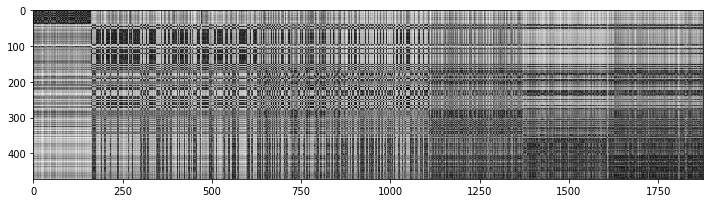

Time performance: 0.013184070587158203 seconds


In [5]:
###### INFORMATION ######
print('\n[INFO]:')

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
print('Histogram train matrix: {:.2f}MB'.format(X_train.nbytes / (1024 * 1000.0)))
print('Histogram test matrix: {:.2f}MB'.format(X_test.nbytes / (1024 * 1000.0)))
print('Train data shape:', X_train.shape)
print('Tain labels shape:', y_train.shape)
print('Test data shape:', X_test.shape)
print('Test labels shape:', y_test.shape)

###### CREATE AND TRAIN CLASSIFIER ######
classifier = kNearestNeighbor()
classifier.train(X_train, y_train)

# Test implementation
dists = classifier.compute_distances_no_loops(X_test)
print('Distance shape:', dists.shape)
plt.figure(figsize=(12, 9))
plt.imshow(dists, interpolation='none')
plt.show()

# Time performance
time = time_function(classifier.compute_distances_no_loops, X_test)
print('Time performance:', time, 'seconds')

### Cross-validation

k = 1, accuracy = 0.095339
k = 1, accuracy = 0.199153
k = 1, accuracy = 0.243644
k = 1, accuracy = 0.338983
k = 1, accuracy = 0.203390
k = 3, accuracy = 0.076271
k = 3, accuracy = 0.171610
k = 3, accuracy = 0.222458
k = 3, accuracy = 0.192797
k = 3, accuracy = 0.199153
k = 5, accuracy = 0.036017
k = 5, accuracy = 0.161017
k = 5, accuracy = 0.213983
k = 5, accuracy = 0.177966
k = 5, accuracy = 0.190678
k = 8, accuracy = 0.021186
k = 8, accuracy = 0.154661
k = 8, accuracy = 0.194915
k = 8, accuracy = 0.152542
k = 8, accuracy = 0.194915
k = 10, accuracy = 0.016949
k = 10, accuracy = 0.141949
k = 10, accuracy = 0.197034
k = 10, accuracy = 0.139831
k = 10, accuracy = 0.194915
k = 12, accuracy = 0.016949
k = 12, accuracy = 0.137712
k = 12, accuracy = 0.197034
k = 12, accuracy = 0.139831
k = 12, accuracy = 0.194915
k = 15, accuracy = 0.004237
k = 15, accuracy = 0.118644
k = 15, accuracy = 0.188559
k = 15, accuracy = 0.125000
k = 15, accuracy = 0.177966
k = 20, accuracy = 0.002119
k = 20, accu

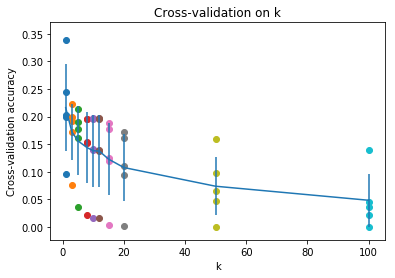

In [6]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []

# Split training data into folds
X_train_folds = np.array(np.array_split(X_train, num_folds))
y_train_folds = np.array(np.array_split(y_train, num_folds))

# A dictionary holding the accuracies to find the best value of k
k_to_accuracies = {}

# Perform k-fold cross validation to find the best value of k
for k in k_choices:
    for j in range(num_folds):
        all_but_one_ind = [i for i in range(num_folds) if i != j]
        X_all_but_one = np.concatenate(X_train_folds[all_but_one_ind])
        y_all_but_one = np.concatenate(y_train_folds[all_but_one_ind])
        
        knn = kNearestNeighbor()
        knn.train(X_all_but_one, y_all_but_one)
        y_pred_k_f = knn.predict(X_train_folds[j], k)
        
        acc = float(sum(y_pred_k_f == y_train_folds[j])) / X_test.shape[0]
        
        if k not in k_to_accuracies:
            k_to_accuracies[k] = []
        k_to_accuracies[k].append(acc)

# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

# Plot the raw observations
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)
    
# Plot the trend line with error bars that corresponde to standard deviation
accuracies_mean = np.array([np.mean(v) for k, v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k, v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

### Best value of k

Based on the cross-validation results above, the best value for k is choosen. The classifier is retrained using all the training data and then tested on the test data. 

In [7]:
best_k = 1

classifier = kNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / X_test.shape[0]
print('Got %d / %d correct' % (num_correct, X_test.shape[0]))
print('Accuracy: %f' % accuracy)

Got 402 / 472 correct
Accuracy: 0.851695


## Full size images with filter

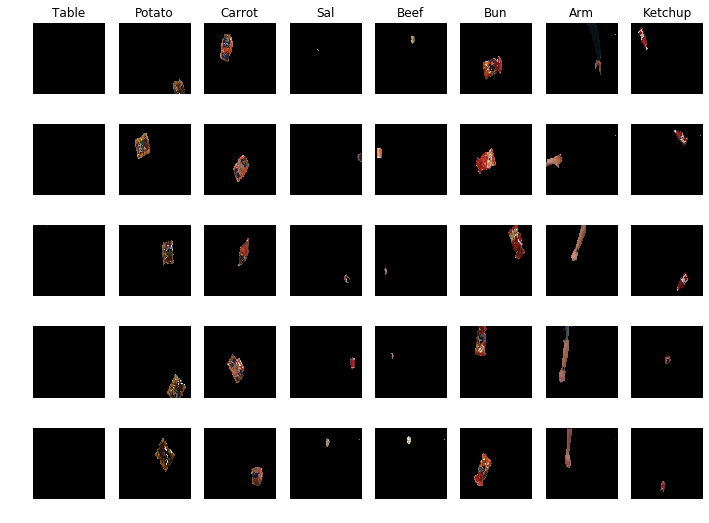

In [8]:
def import_data(X, y, folder, label, show_img):
    """ Imports data """

    lower = (0, 65, 0)
    upper = (179, 255, 255)
    if show_img is True:
        images = []
    for i, img in enumerate(folder):
        img = cv2.imread(img, cv2.IMREAD_COLOR)
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        mask = cv2.inRange(src=hsv, lowerb=lower, upperb=upper)
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (30, 30))
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
        img = cv2.bitwise_and(img, img, mask=mask)
        img = cv2.bitwise_and(img, BGD_MASK)
        hist = extract_hist(img)
        X.append(hist)
        y.append(label)
        if show_img is True:
            image = cv2.resize(img, (448, 448), interpolation=cv2.INTER_CUBIC)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            images.append(image)
    if show_img is True:
        return images

###### IMPORT TRAIN DATA ######
X_train = []
y_train = []
import_data(X_train, y_train, BGD_TRAIN_DIR, 0, False)
import_data(X_train, y_train, POTATO_TRAIN_DIR, 1, False)
import_data(X_train, y_train, CARROT_TRAIN_DIR, 2, False)
import_data(X_train, y_train, CAT_SAL_TRAIN_DIR, 3, False)
import_data(X_train, y_train, CAT_BEEF_TRAIN_DIR, 4, False)
import_data(X_train, y_train, BUN_TRAIN_DIR, 5, False)
import_data(X_train, y_train, ARM_TRAIN_DIR, 6, False)
import_data(X_train, y_train, KETCHUP_TRAIN_DIR, 7, False)

###### IMPORT TEST DATA ######
X_test = []
y_test = []
bgd_imgs = import_data(X_test, y_test, BGD_TEST_DIR, 0, True)
potato_imgs = import_data(X_test, y_test, POTATO_TEST_DIR, 1, True)
carrot_imgs = import_data(X_test, y_test, CARROT_TEST_DIR, 2, True)
cat_sal_imgs = import_data(X_test, y_test, CAT_SAL_TEST_DIR, 3, True)
cat_beef_imgs = import_data(X_test, y_test, CAT_BEEF_TEST_DIR, 4, True)
bun_imgs = import_data(X_test, y_test, BUN_TEST_DIR, 5, True)
arm_imgs = import_data(X_test, y_test, ARM_TEST_DIR, 6, True)
ketchup_imgs = import_data(X_test, y_test, KETCHUP_TEST_DIR, 7, True)

# Visualize data
images = bgd_imgs+potato_imgs+carrot_imgs+cat_sal_imgs+cat_beef_imgs+bun_imgs+arm_imgs+ketchup_imgs
classes = ['Table','Potato','Carrot','Sal','Beef','Bun','Arm','Ketchup']
num_classes = len(classes)
samples_per_class = 5
plt.figure(figsize=(12, 9))
for y, cls in enumerate(classes):
    idxs = [i for i, label in enumerate(y_test) if label == y]
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(images[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()


[INFO]:
Histogram train matrix: 3.75MB
Histogram test matrix: 0.94MB
Train data shape: (1875, 512)
Tain labels shape: (1875,)
Test data shape: (472, 512)
Test labels shape: (472,)
Distance shape: (472, 1875)


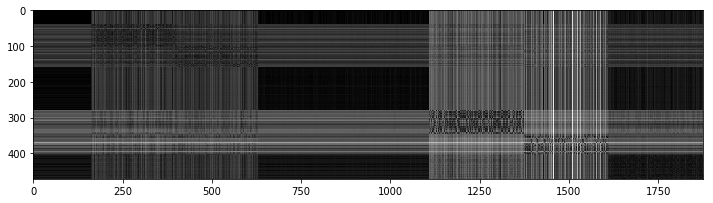

Time performance: 0.012933492660522461 seconds


In [9]:
###### INFORMATION ######
print('\n[INFO]:')

# Show size
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
print('Histogram train matrix: {:.2f}MB'.format(X_train.nbytes / (1024 * 1000.0)))
print('Histogram test matrix: {:.2f}MB'.format(X_test.nbytes / (1024 * 1000.0)))
print('Train data shape:', X_train.shape)
print('Tain labels shape:', y_train.shape)
print('Test data shape:', X_test.shape)
print('Test labels shape:', y_test.shape)

###### CREATE AND TRAIN CLASSIFIER ######
classifier = kNearestNeighbor()
classifier.train(X_train, y_train)

# Test implementation
dists = classifier.compute_distances_no_loops(X_test)
print('Distance shape:', dists.shape)
plt.figure(figsize=(12, 9))
plt.imshow(dists, interpolation='none')
plt.show()

# Time performance
time = time_function(classifier.compute_distances_no_loops, X_test)
print('Time performance:', time, 'seconds')

### Cross-validation

/mnt/sdb1/Robtek/6semester/Bachelorproject/BSc-PRO/knn/knn_classifier.py:47: RuntimeWarning: invalid value encountered in sqrt
  dists = np.sqrt(squared_dist)


k = 1, accuracy = 0.391949
k = 1, accuracy = 0.228814
k = 1, accuracy = 0.269068
k = 1, accuracy = 0.743644
k = 1, accuracy = 0.230932
k = 3, accuracy = 0.389831
k = 3, accuracy = 0.222458
k = 3, accuracy = 0.256356
k = 3, accuracy = 0.720339
k = 3, accuracy = 0.218220
k = 5, accuracy = 0.379237
k = 5, accuracy = 0.220339
k = 5, accuracy = 0.247881
k = 5, accuracy = 0.699153
k = 5, accuracy = 0.220339
k = 8, accuracy = 0.347458
k = 8, accuracy = 0.199153
k = 8, accuracy = 0.228814
k = 8, accuracy = 0.686441
k = 8, accuracy = 0.213983
k = 10, accuracy = 0.332627
k = 10, accuracy = 0.177966
k = 10, accuracy = 0.222458
k = 10, accuracy = 0.682203
k = 10, accuracy = 0.207627
k = 12, accuracy = 0.307203
k = 12, accuracy = 0.175847
k = 12, accuracy = 0.207627
k = 12, accuracy = 0.661017
k = 12, accuracy = 0.205508
k = 15, accuracy = 0.235169
k = 15, accuracy = 0.165254
k = 15, accuracy = 0.205508
k = 15, accuracy = 0.614407
k = 15, accuracy = 0.201271
k = 20, accuracy = 0.148305
k = 20, accu

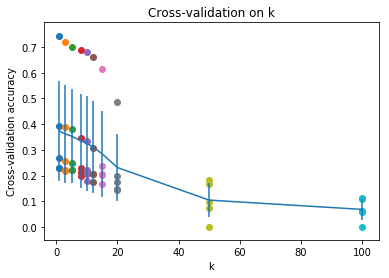

In [10]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []

# Split training data into folds
X_train_folds = np.array(np.array_split(X_train, num_folds))
y_train_folds = np.array(np.array_split(y_train, num_folds))

# A dictionary holding the accuracies to find the best value of k
k_to_accuracies = {}

# Perform k-fold cross validation to find the best value of k
for k in k_choices:
    for j in range(num_folds):
        all_but_one_ind = [i for i in range(num_folds) if i != j]
        X_all_but_one = np.concatenate(X_train_folds[all_but_one_ind])
        y_all_but_one = np.concatenate(y_train_folds[all_but_one_ind])
        
        knn = kNearestNeighbor()
        knn.train(X_all_but_one, y_all_but_one)
        y_pred_k_f = knn.predict(X_train_folds[j], k)
        
        acc = float(sum(y_pred_k_f == y_train_folds[j])) / X_test.shape[0]
        
        if k not in k_to_accuracies:
            k_to_accuracies[k] = []
        k_to_accuracies[k].append(acc)

# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

# Plot the raw observations
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)
    
# Plot the trend line with error bars that corresponde to standard deviation
accuracies_mean = np.array([np.mean(v) for k, v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k, v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

### Best value of k

In [11]:
best_k = 1

classifier = kNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / X_test.shape[0]
print('Got %d / %d correct' % (num_correct, X_test.shape[0]))
print('Accuracy: %f' % accuracy)

Got 442 / 472 correct
Accuracy: 0.936441
